# Advanced Feature Engineering for HAI-21.03 Dataset

This notebook implements improved feature engineering techniques for the HAI-21.03 industrial control system security dataset.

In [1]:
# Import required libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm import tqdm
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="darkgrid")

# Set random seeds for reproducibility
np.random.seed(42)

## 1. Global Variables Setup

In [2]:
# Set paths
DATA_DIR = '../hai-security-dataset/hai-21.03'
OUTPUT_DIR = '../hai-security-dataset/processed'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set parameters
CORRELATION_THRESHOLD = 0.7  # Graph edge correlation threshold

## 2. Load Data

In [3]:
# Define a simple data loader class
class HAIDataLoader:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.train_files = glob.glob(os.path.join(data_dir, 'train*.csv'))
        self.test_files = glob.glob(os.path.join(data_dir, 'test*.csv'))
        self.train_data = {}
        self.test_data = {}
        
        print(f"Found {len(self.train_files)} train files and {len(self.test_files)} test files")
    
    def _preprocess_dataframe(self, df):
        # Convert column names to lowercase for consistency
        df.columns = [col.lower() for col in df.columns]
        
        # Handle missing values
        df = df.fillna(method='ffill').fillna(method='bfill')
        
        # Ensure attack column exists (it might not in training data)
        if 'attack' not in df.columns:
            df['attack'] = 0
        
        return df
    
    def load_data(self):
        # Load training files
        print("Loading train files:")
        for file in self.train_files:
            file_name = os.path.basename(file).split('.')[0]
            df = pd.read_csv(file)
            df = self._preprocess_dataframe(df)
            self.train_data[file_name] = df
            print(f"  {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")
        
        # Load test files
        print("\nLoading test files:")
        for file in self.test_files:
            file_name = os.path.basename(file).split('.')[0]
            df = pd.read_csv(file)
            df = self._preprocess_dataframe(df)
            self.test_data[file_name] = df
            print(f"  {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")
    
    def merge_train_data(self):
        if not self.train_data:
            print("No training data loaded. Call load_data() first.")
            return None
        
        # Merge all training dataframes
        merged_df = pd.concat(list(self.train_data.values()), axis=0, ignore_index=True)
        print(f"Merged training data: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")
        
        return merged_df
    
    def get_feature_columns(self, df=None):
        if df is None:
            if not self.train_data:
                print("No training data loaded. Call load_data() first.")
                return []
            df = list(self.train_data.values())[0]
        
        # Get feature columns excluding time and attack columns
        feature_cols = [col for col in df.columns 
                       if not col.startswith('time') and not col.startswith('attack')]
        
        return feature_cols

In [4]:
# Initialize data loader
data_loader = HAIDataLoader(DATA_DIR)

# Load data
data_loader.load_data()

# Get all training data and merge
train_df = data_loader.merge_train_data()

# Print dataset information
print(f"Training data shape: {train_df.shape}")
print(f"Training data columns: {train_df.columns[:10].tolist()}...")

Found 3 train files and 5 test files
Loading train files:
  train1: 216001 rows, 84 columns
  train2: 226801 rows, 84 columns
  train3: 478801 rows, 84 columns

Loading test files:
  test1: 43201 rows, 84 columns
  test2: 118801 rows, 84 columns
  test3: 108001 rows, 84 columns
  test4: 39601 rows, 84 columns
  test5: 92401 rows, 84 columns
Merged training data: 921603 rows, 84 columns
Training data shape: (921603, 84)
Training data columns: ['time', 'p1_b2004', 'p1_b2016', 'p1_b3004', 'p1_b3005', 'p1_b4002', 'p1_b4005', 'p1_b400b', 'p1_b4022', 'p1_fcv01d']...


## 3. Improved Graph Structure Creation

In [5]:
def create_enhanced_graph(df, correlation_threshold=0.7):
    """
    Create an enhanced graph structure based on column names and their correlations.
    
    Args:
        df (pd.DataFrame): DataFrame with sensor/actuator columns
        correlation_threshold (float): Threshold for adding edges between components in the graph
        
    Returns:
        nx.Graph: NetworkX graph representing the system
    """
    G = nx.Graph()
    
    # Extract columns excluding time and attack columns
    cols = [col for col in df.columns if not col.startswith('time') and not col.startswith('attack')]
    
    # Identify subsystems from column names
    subsystems = set()
    for col in cols:
        parts = col.split('_')
        if len(parts) >= 2:
            subsystems.add(parts[0])
    
    print(f"Identified subsystems: {subsystems}")
    
    # Add nodes for each subsystem
    for subsystem in subsystems:
        G.add_node(subsystem, type='subsystem')
    
    # Add nodes for each sensor/actuator
    for col in cols:
        parts = col.split('_')
        if len(parts) >= 2:
            subsystem = parts[0]
            component = '_'.join(parts[1:])
            
            # Add node for component
            G.add_node(col, type='component', subsystem=subsystem)
            
            # Add edge between component and its subsystem
            G.add_edge(subsystem, col, weight=1.0)
    
    # Add edges between components based on correlation
    corr_matrix = df[cols].corr().abs()
    
    # Add edges between components based on correlation
    edge_count = 0
    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i < j and corr_matrix.loc[col1, col2] > correlation_threshold:
                G.add_edge(col1, col2, weight=corr_matrix.loc[col1, col2])
                edge_count += 1
    
    print(f"Added {edge_count} correlation-based edges")
    
    # Add edges between subsystems based on component connections
    subsystem_connections = {}
    for subsys1 in subsystems:
        for subsys2 in subsystems:
            if subsys1 < subsys2:
                subsystem_connections[(subsys1, subsys2)] = 0
    
    for u, v in G.edges():
        if G.nodes[u].get('type') == 'component' and G.nodes[v].get('type') == 'component':
            subsys_u = G.nodes[u].get('subsystem')
            subsys_v = G.nodes[v].get('subsystem')
            if subsys_u and subsys_v and subsys_u != subsys_v:
                key = (min(subsys_u, subsys_v), max(subsys_u, subsys_v))
                subsystem_connections[key] = subsystem_connections.get(key, 0) + 1
    
    # Add edges between subsystems
    for (subsys1, subsys2), count in subsystem_connections.items():
        if count > 0:
            G.add_edge(subsys1, subsys2, weight=count, type='subsystem_connection')
            print(f"Added edge between subsystems {subsys1} and {subsys2} with weight {count}")
    
    return G

In [6]:
# Create enhanced graph
G = create_enhanced_graph(train_df, CORRELATION_THRESHOLD)

# Print graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Count node types
node_types_count = {}
for _, data in G.nodes(data=True):
    if 'type' in data:
        node_type = data['type']
        if node_type not in node_types_count:
            node_types_count[node_type] = 0
        node_types_count[node_type] += 1

print("\nNode types:")
for node_type, count in node_types_count.items():
    print(f"  {node_type}: {count}")

Identified subsystems: {'p1', 'p2', 'p4', 'p3'}
Added 101 correlation-based edges
Added edge between subsystems p1 and p4 with weight 6
Added edge between subsystems p3 and p4 with weight 5
Number of nodes: 83
Number of edges: 182

Node types:
  subsystem: 4
  component: 79


Showing subgraph with 50 nodes and 148 edges


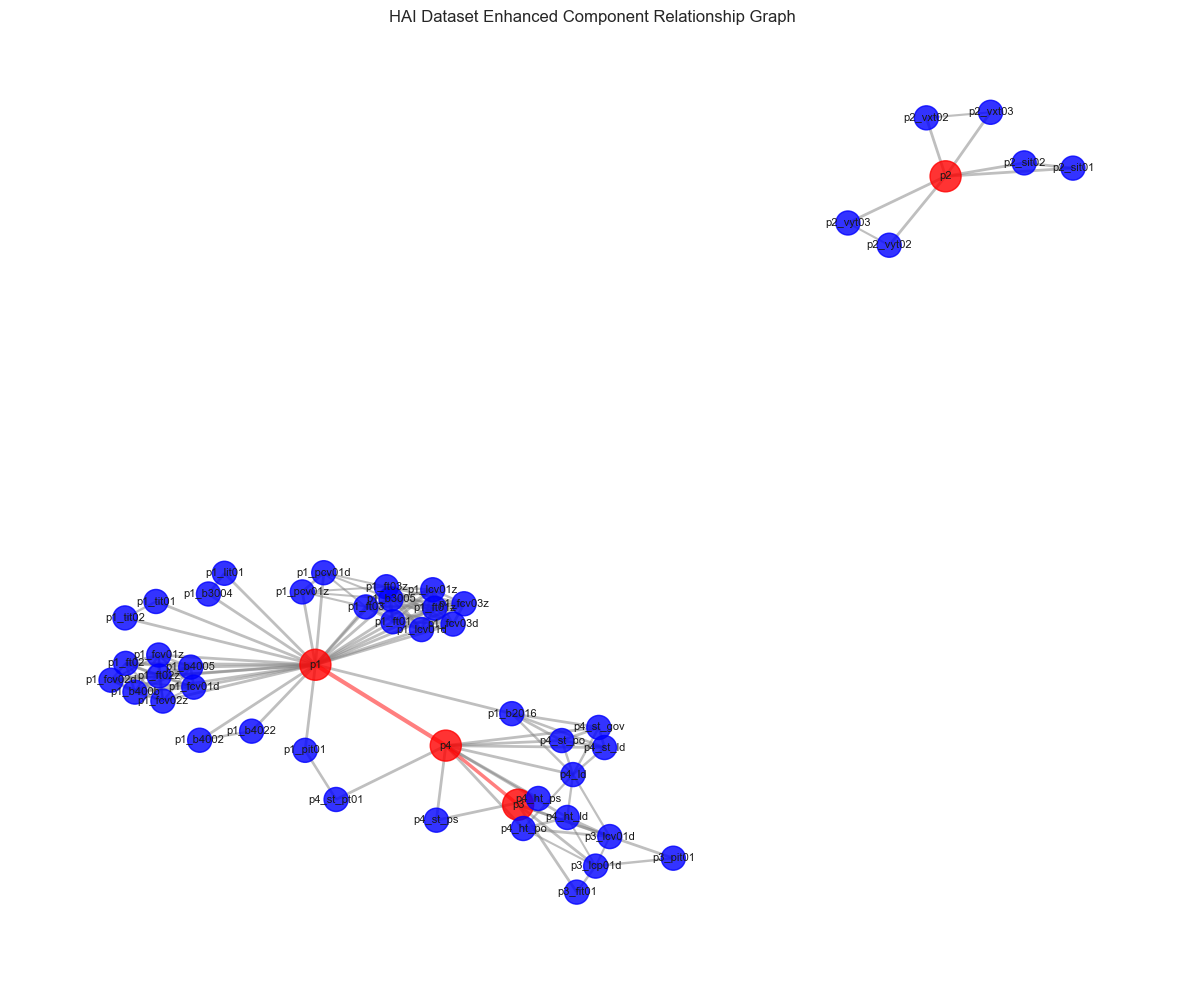

In [7]:
# Visualize graph
def visualize_graph(G, max_nodes=50):
    """
    Visualize a graph, limiting to max_nodes if the graph is too large.
    
    Args:
        G (nx.Graph): NetworkX graph
        max_nodes (int): Maximum number of nodes to display
    """
    if G.number_of_nodes() > max_nodes:
        # Get the most connected nodes
        degrees = dict(G.degree())
        top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:max_nodes]
        G_sub = G.subgraph(top_nodes)
        print(f"Showing subgraph with {G_sub.number_of_nodes()} nodes and {G_sub.number_of_edges()} edges")
        G_vis = G_sub
    else:
        G_vis = G
    
    plt.figure(figsize=(12, 10))
    
    # Set node colors based on type
    node_colors = []
    node_sizes = []
    for node in G_vis.nodes():
        node_type = G_vis.nodes[node].get('type', 'unknown')
        if node_type == 'subsystem':
            node_colors.append('red')
            node_sizes.append(500)
        elif node_type == 'component':
            node_colors.append('blue')
            node_sizes.append(300)
        else:
            node_colors.append('gray')
            node_sizes.append(300)
    
    # Set edge widths and colors based on type and weight
    edge_widths = []
    edge_colors = []
    for u, v, data in G_vis.edges(data=True):
        if data.get('type') == 'subsystem_connection':
            edge_colors.append('red')
            edge_widths.append(data.get('weight', 1.0) * 0.5)
        else:
            edge_colors.append('gray')
            edge_widths.append(data.get('weight', 1.0) * 2)
    
    # Draw the graph
    pos = nx.spring_layout(G_vis, seed=42)
    nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_edges(G_vis, pos, width=edge_widths, edge_color=edge_colors, alpha=0.5)
    nx.draw_networkx_labels(G_vis, pos, font_size=8)
    
    plt.title("HAI Dataset Enhanced Component Relationship Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize graph
visualize_graph(G)

## 4. Advanced Time Series Feature Engineering

In [8]:
def extract_time_series_features(df, window_sizes=[10, 30, 60]):
    """
    Extract advanced time series features from the data.
    
    Args:
        df (pd.DataFrame): Input dataframe
        window_sizes (list): List of window sizes for rolling features
        
    Returns:
        pd.DataFrame: DataFrame with additional time series features
    """
    df_processed = df.copy()
    
    # Extract columns excluding time and attack columns
    cols = [col for col in df.columns if not col.startswith('time') and not col.startswith('attack')]
    
    # Add rolling window statistics
    for window in window_sizes:
        for col in tqdm(cols, desc=f"Adding rolling window features (window={window})"):
            # Basic rolling statistics
            df_processed[f"{col}_rolling_{window}_mean"] = df[col].rolling(window=window).mean()
            df_processed[f"{col}_rolling_{window}_std"] = df[col].rolling(window=window).std()
            df_processed[f"{col}_rolling_{window}_min"] = df[col].rolling(window=window).min()
            df_processed[f"{col}_rolling_{window}_max"] = df[col].rolling(window=window).max()
            
            # Advanced rolling statistics
            df_processed[f"{col}_rolling_{window}_median"] = df[col].rolling(window=window).median()
            df_processed[f"{col}_rolling_{window}_skew"] = df[col].rolling(window=window).skew()
            df_processed[f"{col}_rolling_{window}_kurt"] = df[col].rolling(window=window).kurt()
            
            # Trend features
            roll_mean = df[col].rolling(window=window).mean()
            df_processed[f"{col}_rolling_{window}_trend"] = roll_mean.diff()
            
            # Volatility features
            df_processed[f"{col}_rolling_{window}_volatility"] = df[col].rolling(window=window).std() / df[col].rolling(window=window).mean().abs()
    
    # Add lag features
    lag_values = [1, 5, 10]
    for lag in lag_values:
        for col in tqdm(cols, desc=f"Adding lag features (lag={lag})"):
            df_processed[f"{col}_lag_{lag}"] = df[col].shift(lag)
            df_processed[f"{col}_diff_{lag}"] = df[col].diff(lag)
    
    # Add rate of change features
    for window in window_sizes:
        for col in tqdm(cols, desc=f"Adding rate of change features (window={window})"):
            df_processed[f"{col}_roc_{window}"] = df[col].pct_change(periods=window)
    
    # Fill NaN values
    df_processed = df_processed.fillna(method='bfill').fillna(method='ffill')
    
    return df_processed

## 5. Enhanced Graph-Based Feature Engineering

In [9]:
def enhanced_graph_based_feature_engineering(df, G):
    """
    Create enhanced graph-based features.
    
    Args:
        df (pd.DataFrame): DataFrame with sensor/actuator data
        G (nx.Graph): NetworkX graph
        
    Returns:
        pd.DataFrame: DataFrame with additional graph-based features
    """
    df_processed = df.copy()
    
    # Extract columns excluding time and attack columns
    cols = [col for col in df.columns if not col.startswith('time') and not col.startswith('attack')]
    
    # Identify subsystems
    subsystems = [node for node, data in G.nodes(data=True) if data.get('type') == 'subsystem']
    print(f"Processing subsystems: {subsystems}")
    
    # Add subsystem-level features
    for subsystem in subsystems:
        # Get components for this subsystem
        subsystem_components = [node for node, data in G.nodes(data=True) 
                               if data.get('type') == 'component' and data.get('subsystem') == subsystem]
        
        if subsystem_components:
            print(f"Processing {subsystem} with {len(subsystem_components)} components")
            
            # Calculate subsystem-level statistics
            df_processed[f"{subsystem}_mean"] = df[subsystem_components].mean(axis=1)
            df_processed[f"{subsystem}_std"] = df[subsystem_components].std(axis=1)
            df_processed[f"{subsystem}_max"] = df[subsystem_components].max(axis=1)
            df_processed[f"{subsystem}_min"] = df[subsystem_components].min(axis=1)
            df_processed[f"{subsystem}_median"] = df[subsystem_components].median(axis=1)
            df_processed[f"{subsystem}_range"] = df_processed[f"{subsystem}_max"] - df_processed[f"{subsystem}_min"]
            df_processed[f"{subsystem}_iqr"] = df[subsystem_components].quantile(0.75, axis=1) - df[subsystem_components].quantile(0.25, axis=1)
            
            # Calculate z-scores for each component within its subsystem
            for component in subsystem_components:
                mean = df_processed[f"{subsystem}_mean"]
                std = df_processed[f"{subsystem}_std"].replace(0, 1e-10)  # Avoid division by zero
                df_processed[f"{component}_zscore"] = (df[component] - mean) / std
    
    # Add cross-subsystem features
    for i, s1 in enumerate(subsystems):
        for j, s2 in enumerate(subsystems):
            if i < j:
                # Check if subsystems are connected in the graph
                if G.has_edge(s1, s2):
                    print(f"Adding cross-subsystem features for {s1} and {s2}")
                    
                    # Calculate ratio and difference between subsystem means
                    if f"{s1}_mean" in df_processed.columns and f"{s2}_mean" in df_processed.columns:
                        s2_mean = df_processed[f"{s2}_mean"].replace(0, 1e-10)  # Avoid division by zero
                        df_processed[f"{s1}_{s2}_ratio"] = df_processed[f"{s1}_mean"] / s2_mean
                        df_processed[f"{s1}_{s2}_diff"] = df_processed[f"{s1}_mean"] - df_processed[f"{s2}_mean"]
                        df_processed[f"{s1}_{s2}_sum"] = df_processed[f"{s1}_mean"] + df_processed[f"{s2}_mean"]
                        df_processed[f"{s1}_{s2}_product"] = df_processed[f"{s1}_mean"] * df_processed[f"{s2}_mean"]
                        
                        # Calculate correlation between subsystems over rolling windows
                        for window in [30, 60, 120]:
                            df_processed[f"{s1}_{s2}_rolling_{window}_corr"] = df_processed[f"{s1}_mean"].rolling(window).corr(df_processed[f"{s2}_mean"])
    
    # Add graph centrality features
    print("Calculating graph centrality measures...")
    
    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    
    # Add centrality-weighted features
    for col in cols:
        if col in G.nodes():
            # Weight by degree centrality
            df_processed[f"{col}_degree_weighted"] = df[col] * degree_centrality.get(col, 0)
            
            # Weight by betweenness centrality
            df_processed[f"{col}_betweenness_weighted"] = df[col] * betweenness_centrality.get(col, 0)
            
            # Weight by closeness centrality
            df_processed[f"{col}_closeness_weighted"] = df[col] * closeness_centrality.get(col, 0)
    
    # Add community detection based features
    print("Detecting communities in the graph...")
    communities = nx.community.greedy_modularity_communities(G)
    
    # Create a mapping from node to community
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i
    
    # Add community-based features
    for i, community in enumerate(communities):
        community_cols = [col for col in cols if col in community]
        if community_cols:
            print(f"Adding features for community {i} with {len(community_cols)} components")
            df_processed[f"community_{i}_mean"] = df[community_cols].mean(axis=1)
            df_processed[f"community_{i}_std"] = df[community_cols].std(axis=1)
            df_processed[f"community_{i}_max"] = df[community_cols].max(axis=1)
            df_processed[f"community_{i}_min"] = df[community_cols].min(axis=1)
    
    # Fill NaN values
    df_processed = df_processed.fillna(method='bfill').fillna(method='ffill')
    
    return df_processed

In [ ]:
# Apply time series feature engineering to training data
print("Applying time series feature engineering...")
train_df_ts = extract_time_series_features(train_df, window_sizes=[10, 30])

# Apply graph-based feature engineering
print("\nApplying graph-based feature engineering...")
train_df_processed = enhanced_graph_based_feature_engineering(train_df_ts, G)

# Print feature counts
print(f"\nOriginal train features: {train_df.shape[1]}")
print(f"After time series features: {train_df_ts.shape[1]}")
print(f"Final processed features: {train_df_processed.shape[1]}")
print(f"New features added: {train_df_processed.shape[1] - train_df.shape[1]}")

Applying time series feature engineering...


Adding rate of change features (window=30): 100%|██████████| 79/79 [00:02<00:00, 37.63it/s]



Applying graph-based feature engineering...


In [ ]:
# Visualize new features
new_features = [col for col in train_df_processed.columns if col not in train_df.columns]
print(f"New features: {len(new_features)}")

# Group new features by type
rolling_features = [f for f in new_features if 'rolling' in f]
lag_features = [f for f in new_features if 'lag' in f or 'diff' in f]
subsystem_features = [f for f in new_features if any(s in f for s in ['_mean', '_std', '_max', '_min', '_median', '_range', '_iqr']) and not any(x in f for x in ['rolling', 'lag', 'diff', 'community'])]
cross_subsystem_features = [f for f in new_features if any(x in f for x in ['ratio', 'diff', 'sum', 'product', 'corr'])]
centrality_features = [f for f in new_features if any(x in f for x in ['degree', 'betweenness', 'closeness'])]
community_features = [f for f in new_features if 'community' in f]
other_features = [f for f in new_features if f not in rolling_features + lag_features + subsystem_features + cross_subsystem_features + centrality_features + community_features]

# Print feature counts by type
print(f"Rolling features: {len(rolling_features)}")
print(f"Lag features: {len(lag_features)}")
print(f"Subsystem features: {len(subsystem_features)}")
print(f"Cross-subsystem features: {len(cross_subsystem_features)}")
print(f"Centrality features: {len(centrality_features)}")
print(f"Community features: {len(community_features)}")
print(f"Other features: {len(other_features)}")

In [ ]:
# Plot a few examples of new features
sample_size = 1000  # Take a sample for visualization

# Sample from each feature type
feature_samples = {
    'Rolling Features': rolling_features[:2],
    'Lag Features': lag_features[:2],
    'Subsystem Features': subsystem_features[:2],
    'Cross-Subsystem Features': cross_subsystem_features[:2] if cross_subsystem_features else [],
    'Centrality Features': centrality_features[:2] if centrality_features else [],
    'Community Features': community_features[:2] if community_features else []
}

# Plot samples
for feature_type, features in feature_samples.items():
    if features:
        plt.figure(figsize=(15, 5 * len(features)))
        for i, feature in enumerate(features):
            plt.subplot(len(features), 1, i+1)
            plt.plot(train_df_processed[feature].iloc[:sample_size])
            plt.title(f'{feature_type}: {feature}')
            plt.xlabel('Time')
            plt.ylabel('Value')
        plt.tight_layout()
        plt.show()

## 6. Apply Feature Engineering to Test Data

In [ ]:
# Apply feature engineering to test data
test_data_processed = {}

for name, df in data_loader.test_data.items():
    print(f"Processing {name}...")
    # Apply time series feature engineering
    df_ts = extract_time_series_features(df, window_sizes=[10, 30])
    
    # Apply graph-based feature engineering
    df_processed = enhanced_graph_based_feature_engineering(df_ts, G)
    
    test_data_processed[name] = df_processed
    print(f"Processed {name}: {df.shape[1]} original features, {df_processed.shape[1]} processed features")

## 7. Save Processed Data

In [ ]:
# Save processed training data
train_df_processed.to_csv(os.path.join(OUTPUT_DIR, 'train_processed_enhanced.csv'), index=False)
print(f"Saved processed training data to {os.path.join(OUTPUT_DIR, 'train_processed_enhanced.csv')}")

# Save test data
for name, df in test_data_processed.items():
    df.to_csv(os.path.join(OUTPUT_DIR, f"{name}_processed_enhanced.csv"), index=False)
    print(f"Saved processed test data to {os.path.join(OUTPUT_DIR, f'{name}_processed_enhanced.csv')}")

# Save graph
import pickle
with open(os.path.join(OUTPUT_DIR, 'enhanced_graph.pkl'), 'wb') as f:
    pickle.dump(G, f)
print(f"Saved enhanced graph to {os.path.join(OUTPUT_DIR, 'enhanced_graph.pkl')}")